In [10]:
%matplotlib inline
import os 
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
from rasterio import features
from affine import Affine
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl import geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import t, norm, ttest_1samp, gaussian_kde
import xesmf as xe
from time import time
import warnings
from random import choices, sample, choice
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
import re
from multiprocessing import Pool
from functools import partial
warnings.filterwarnings('ignore')

In [ ]:
def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xarray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    
    def transform_from_latlon(lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale

    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))

def get_dowy(date):
    if date is None:
        return np.nan
    date = pd.to_datetime(date)
    if date.month >= 10:
        dowy = date.dayofyear - pd.to_datetime(f"{date.year}-10-01").dayofyear + 1
    else: 
        dowy = date.dayofyear + 92
    if date.year % 4 == 0 and dowy>=92+61:
        dowy = dowy -1
    return dowy

In [ ]:
root_dir = "/dartfs-hpc/rc/lab/C/CMIG"
data_dir = os.path.join(root_dir, "agottlieb",'git_repos',"snow_drought", "data")
basin_dir = os.path.join(data_dir,'basin')
fig_dir = os.path.join(root_dir, "agottlieb",'git_repos',"snow_drought", "figures")

In [ ]:
grdc_basins = gpd.read_file(os.path.join(data_dir, "boundaries", "grdc_basins"), layer="mrb_basins")
basin_ids = {k: i for i, k in enumerate(grdc_basins.RIVER_BASI)}
basin_ids_rev = {v:k for k,v in basin_ids.items()}
basin_shapes = [(shape, n) for n, shape in enumerate(grdc_basins.geometry)]

In [ ]:
basin_ensemble = []
for prod in os.listdir(basin_dir):
    prod_dir = os.path.join(basin_dir,prod)
    prod_files = [os.path.join(prod_dir,f) for f in os.listdir(prod_dir)]
    prod_files.sort()
    if prod == 'SNOTEL':
        continue
    prod_ds = xr.concat([xr.open_dataset(f) for f in prod_files],dim='time').resample(time='1D').mean()
    prod_ds = prod_ds.assign_coords(product=prod)
    basin_ensemble.append(prod_ds)
    print(prod)
basin_ensemble = xr.concat(basin_ensemble,dim='product')
ens_mean = basin_ensemble.mean("product")
ens_mean = ens_mean.assign_coords(product='Ens. mean')
basin_ensemble = xr.concat([basin_ensemble,ens_mean],dim='product')

In [ ]:
basin_ensemble = basin_ensemble.sel(time=basin_ensemble['time'][~((basin_ensemble['time.month']==2)&(basin_ensemble['time.day']==29))])

In [ ]:
prod='SNOTEL'
prod_dir = os.path.join(basin_dir,prod)
prod_files = [os.path.join(prod_dir,f) for f in os.listdir(prod_dir)]
prod_files.sort()
prod_files = prod_files[-18:-2]
snotel_ds = xr.open_mfdataset(prod_files).load()
snotel_ds = snotel_ds.rename({"SWE":"SNOMAS"})
snotel_ds = snotel_ds.assign_coords(product='SNOTEL')

basin_ensemble = basin_ensemble.sel(basin=snotel_ds['basin'].values)
basin_ensemble = xr.concat([basin_ensemble,snotel_ds[['SNOMAS']]],dim='product')

In [ ]:
sd_metrics = basin_ensemble['SNOMAS'].resample(time='AS-OCT').max().to_dataset(name='peak_swe')
sd_metrics['apr1_swe'] = basin_ensemble['SNOMAS'].sel(time=basin_ensemble['time'][(basin_ensemble['time.month']==4)&(basin_ensemble['time.day']==1)]).resample(time='AS-OCT').mean()
swei = basin_ensemble['SNOMAS'].rolling(time=90).sum().groupby("time.dayofyear").apply(lambda x: norm.ppf((x.rank("time")-0.44)/(x.count("time")+0.12)))
sd_metrics['swei'] = swei.sel(time=swei['time'][swei['time.season']=='MAM']).resample(time='AS-OCT').min()
diff_clim = basin_ensemble['SNOMAS'].groupby("time.dayofyear").apply(lambda x: x-x.median())
sd_metrics['swe_deficit'] = diff_clim.sel(time=diff_clim['time'][diff_clim['time.season']=='MAM']).resample(time='AS-OCT').sum(min_count=1)

peak_dates = basin_ensemble['SNOMAS'].resample(time='AS-OCT').apply(lambda x: x.idxmax("time"))
peak_dates = xr.apply_ufunc(get_dowy,peak_dates,input_core_dims=[[]],output_core_dims=[[]],vectorize=True)
sd_metrics['peak_date'] = peak_dates

In [14]:
# sd_metrics = sd_metrics.to_dataframe().reset_index()

grid = xr.Dataset({'lat':np.arange(0.25,90.25,0.5),
                   'lon':np.arange(-179.75,180.25,0.5)})
basin_grid = rasterize(basin_shapes,coords=grid.coords)
basin_grid.name='basin'
basin_grid = basin_grid.to_dataframe().reset_index()

sd_metrics = sd_metrics.merge(basin_grid,on='basin',how='outer')
sd_metrics = xr.Dataset.from_dataframe(sd_metrics.set_index(["product","time","lat","lon"]))
sd_metrics.to_netcdf(os.path.join(data_dir,'basin_snow_drought_metrics.nc'))

In [16]:
if not os.path.exists(os.path.join(data_dir,'prism.nc')):
    prism_dir = os.path.join(root_dir,'Data','Observations','PRISM')
    prism_tmean_files = [os.path.join(prism_dir,'tmean',f) for f in os.listdir(os.path.join(prism_dir,'tmean'))]
    prism_tmean_files.sort()

    prism_ppt_files = [os.path.join(prism_dir,'ppt',f) for f in os.listdir(os.path.join(prism_dir,'ppt'))]
    prism_ppt_files.sort()

    prism_tmean = xr.open_mfdataset(prism_tmean_files[:-3])

    # average temperature from first half of WY
    prism_tmean_ondjfm = prism_tmean.sel(time=prism_tmean['time'][(prism_tmean['time.month']>=10)|(prism_tmean['time.month']<=3)]).resample(time='AS-OCT').mean()

    prism_ppt = xr.open_mfdataset(prism_ppt_files[:-1])
    prism_ppt = prism_ppt.rename({'__xarray_dataarray_variable__':'ppt'})
    prism_ppt['lat'] = prism_tmean['lat']
    prism_ppt['lon'] = prism_tmean['lon']

    # cumulative precipitation from first half of WY
    prism_ppt_ondjfm = prism_ppt.sel(time=prism_ppt['time'][(prism_ppt['time.month']>=10)|(prism_ppt['time.month']<=3)]).resample(time="AS-OCT").sum()
    prism_tmean_ondjfm['ppt'] = prism_ppt_ondjfm['ppt']

    ds_out = xr.Dataset({'lat':np.arange(0.25,90.25,0.5),
                         'lon':np.arange(-179.75,180.25,0.5)})
    regridder = xe.Regridder(prism_tmean_ondjfm,ds_out,'bilinear')
    prism_regrid = regridder(prism_tmean_ondjfm)

    prism_regrid.to_netcdf(os.path.join(data_dir,'prism.nc'))

In [18]:
prism = xr.open_dataset(os.path.join(data_dir,'prism.nc'))
# add PRISM data to SWE dataset
sd_metrics = sd_metrics.assign(tmean=(('time','lat','lon'),prism['tmean'].sel(time=sd_metrics['time'])),
                               ppt=(('time','lat','lon'),prism['ppt'].sel(time=sd_metrics['time'])))

# clip to CONUS
sd_metrics = sd_metrics.sel(lat=slice(24,50),lon=slice(-125,-66))

# calculate T and P anomalies relative to climatology
sd_metrics['t_anom'] = sd_metrics['tmean']-sd_metrics['tmean'].mean("time")
sd_metrics['p_anom'] = sd_metrics['ppt']/sd_metrics['ppt'].median("time")
                                     

In [19]:
usdm = xr.open_dataset(os.path.join(data_dir,'usdm.nc'))
usdm["drought_class"] = usdm["drought_class"].fillna(-1)
usdm = usdm.where(usdm.sum("time")!= -len(usdm["time"]))
usdm["onset_intensification"] = (usdm["drought_class"] - usdm["drought_class"].shift(time=1)) # identify state changes in drought
usdm["onset_intensification"] = usdm["onset_intensification"].clip(max=1) # clip to 1 to make binary (in case increase by >=2)

usdm_max = usdm.where((usdm["time.month"]>=4) & (usdm["time.month"]<=9)).resample(time="AS-OCT").max() # most severe AMJJAS drought class
usdm_max['drought_bin'] = ((usdm_max["drought_class"]>=1) & (usdm_max["onset_intensification"]==1)).astype(int)
sd_metrics = xr.merge([sd_metrics,usdm_max],join='inner')

In [20]:
def ets(y_true, y_pred):
    """
    Equitable threat score metric
    """
    hits = (y_true[y_pred==1]).sum()
    misses = (y_true[y_pred==0]).sum()
    false_alarms = (y_pred[y_true==0]).sum()
    correct_rejections = ((y_pred==0) & (y_true==0)).astype(int).sum()
    E = ((hits+misses)*(hits+false_alarms))/len(y_true)
    ets = (hits-E)/(hits+misses+false_alarms-E)
    return ets


In [21]:
# get basins that contain SNOTEL sites
with xr.open_dataset(os.path.join(root_dir,'Data','Observations','SNOTEL','snotel_basin_yearly_stats.nc')) as ds:
    snotel_basins = ds['basin']
    map_dict = dict(zip(grdc_basins['MRBID'],grdc_basins.index))
    snotel_basins = np.vectorize(map_dict.get)(snotel_basins.values)
    snotel_basins = snotel_basins[snotel_basins!=basin_ids['NELSON']]

In [22]:
basin_data = [sd_metrics.where(sd_metrics['basin']==b) for b in snotel_basins]

In [23]:
def basin_null(basin_data):
    """
    Get 10x 5-fold cross-validation estimates of forecast skill from null model (T & P only)
    """
    stacked = basin_data.stack(z=("time","lat","lon"))
    X1 = stacked['t_anom'].values.reshape(-1,1)
    X2 = stacked['p_anom'].values.reshape(-1,1)
    X = np.concatenate([X1,X2],axis=1)
    y = stacked['drought_bin'].values
    
    X = X[~np.isnan(y),:]
    y = y[~np.isnan(y)]
    X = np.nan_to_num(X,0.5)
    
    rkf = RepeatedStratifiedKFold(n_splits=5,n_repeats=10,random_state=42)
    lr = LogisticRegression()
    ets_cv = cross_val_score(lr,X,y,scoring=make_scorer(ets),cv=rkf,n_jobs=-1,verbose=1)

    return ets_cv

if not os.path.exists(os.path.join(data_dir,'ets','basin_ets_null.csv')):
    pool = Pool(10)
    res = pool.map(basin_null,basin_data)
    null_df = pd.DataFrame(res,index=snotel_basins)
    null_df.index.name = 'basin'
    null_df.to_csv(os.path.join(data_dir,'ets','basin_ets_null.csv'))
    pool.close()
else:
    null_df = pd.read_csv(os.path.join(data_dir,'ets','basin_ets_null.csv')).set_index("basin")

In [27]:
# snow drought classifications based on definitions from the literature
sd_metrics['peak_swe_anom'] = (sd_metrics['peak_swe']-sd_metrics['peak_swe'].mean("time"))/sd_metrics['peak_swe'].std("time")
sd_metrics['apr1_swe_anom'] = (sd_metrics['apr1_swe']-sd_metrics['apr1_swe'].mean("time"))/sd_metrics['apr1_swe'].std("time")
sd_metrics['peak_date_anom'] = (sd_metrics['peak_date']-sd_metrics['peak_date'].mean("time"))/sd_metrics['peak_date'].std("time")


# Huning & AghaKouchak (2020): SWEI < -0.8 (continuous)
sd_ha20 = (sd_metrics["swei"] < -0.8).astype(int).where(~xr.ufuncs.isnan(sd_metrics["swei"]))
sd_ha20.name = "snow_drought"
sd_ha20 = sd_ha20.assign_coords(definition="ha20")

# Harpold et al. (2017): < clim. Apr. 1 SWE 
sd_h17 = (sd_metrics["apr1_swe_anom"] < 0).astype(int).where(~xr.ufuncs.isnan(sd_metrics["apr1_swe_anom"]))
sd_h17.name = "snow_drought"
sd_h17 = sd_h17.assign_coords(definition="h17")

# Marshall et al. (2019): < 25th %ile peak SWE
sd_m19_low = (sd_metrics["peak_swe_anom"]<norm.ppf(0.25)).astype(int).where(~xr.ufuncs.isnan(sd_metrics["peak_swe_anom"]))
sd_m19_low.name = "snow_drought"
sd_m19_low = sd_m19_low.assign_coords(definition="m19_low")

# Marshall et al. (2019): < 25th %ile peak SWE date
sd_m19_early = (sd_metrics["peak_date_anom"]<norm.ppf(0.25)).astype(int).where(~xr.ufuncs.isnan(sd_metrics["peak_date_anom"]))
sd_m19_early.name = "snow_drought"
sd_m19_early = sd_m19_early.assign_coords(definition="m19_early")

# Dierauer et al. (2019): < clim. peak SWE
sd_d19 = (sd_metrics["peak_swe_anom"]<0).astype(int).where(~xr.ufuncs.isnan(sd_metrics["peak_swe_anom"]))
sd_d19.name="snow_drought"
sd_d19 = sd_d19.assign_coords(definition="d19")

# Hatchett & McEvoy (2017): < clim. SWE (continuous)
sd_hm17 = (sd_metrics["swe_deficit"]<0).astype(int).where(~xr.ufuncs.isnan(sd_metrics["swe_deficit"]))
sd_hm17.name="snow_drought"
sd_hm17 = sd_d19.assign_coords(definition="hm17")

# combine all definitions 
def_ds = xr.concat([sd_ha20, sd_h17, sd_m19_low, sd_m19_early, sd_d19, sd_hm17],dim="definition")

# merge snow drought and USDM datasets
def_ds = def_ds.sel(lat=slice(24,50),lon=slice(-125,-66)) # clip to US
def_ds = xr.merge([def_ds,usdm_max],join='inner')
data_def_combos = def_ds.drop_sel(product='Ens. mean',).stack(data_def=("definition","product")) # make data-definition combos single dimension
data_def_combos['tmean'] = sd_metrics['tmean']
data_def_combos['ppt'] = sd_metrics['ppt']
data_def_combos['t_anom'] = sd_metrics['t_anom']
data_def_combos['p_anom'] = sd_metrics['p_anom']
data_def_combos['basin'] = sd_metrics['basin'].mean("product").mean("time")

In [ ]:
def basin_data_def(data_def,basin,data):
    """
    Get 10x 5-fold cross-validation estimates of forecast skill from model that includes each individual dataset-definition combination, as well as T & P
    """
    basin_data = data.sel(data_def=data_def).where(data['basin']==basin).stack(z=('time','lat','lon'))
    X1 = basin_data['t_anom'].values.reshape(-1,1)
    X2 = basin_data['p_anom'].values.reshape(-1,1)
    X3 = basin_data['snow_drought'].values.reshape(-1,1)
    X = np.concatenate([X1,X2,X3],axis=1)
    y = basin_data['drought_bin'].values
    
    X = X[~np.isnan(y),:]
    y = y[~np.isnan(y)]
    X = np.nan_to_num(X,0.5)
    
    rkf = RepeatedStratifiedKFold(n_splits=5,n_repeats=10,random_state=42)
    lr = LogisticRegression()
    ets_cv = cross_val_score(lr,X,y,scoring=make_scorer(ets),cv=rkf,n_jobs=-1,verbose=1)
    return ets_cv

# get cross-val estimates of ETS for each dataset-definition combination in each basin, save to separate file
for b in np.sort(snotel_basins):
    if not os.path.isdir(os.path.join(data_dir,'ets','basin_ets')):
        os.makedirs(os.path.join(data_dir,'ets','basin_ets'))
    if not os.path.exists(os.path.join(data_dir,'ets','basin_ets',f'{basin_ids_rev[b]}.csv')):
        pool = Pool(8)
        p_func = partial(basin_data_def,basin=b,data=data_def_combos)
        res = pool.map(p_func,data_def_combos['data_def'].values)
        basin_df = pd.DataFrame(res,index=data_def_combos['data_def'].values)
        basin_df['basin'] = b
        basin_df.index = pd.MultiIndex.from_tuples(basin_df.index,names=['definition','product'])
        basin_df = basin_df.reset_index().set_index(['basin','definition','product'])
        basin_df.to_csv(os.path.join(data_dir,'ets','basin_ets',f'{basin_ids_rev[b]}.csv'))
        pool.close()
        print(b, "complete")
    else:
        print(b, 'already complete')

In [28]:
# combine all separate basin files into one DataFrame
basin_df = pd.concat([pd.read_csv(os.path.join(data_dir,'ets','basin_ets',f'{basin_ids_rev[b]}.csv')).set_index(["basin","definition","product"]) for b in snotel_basins])

In [29]:
# median estimate of forecast skill from all cross-validation estimates for each data-def combo in each basin
ets_med = basin_df.median(axis=1).reset_index().rename(columns={0:'ets'})

In [30]:
def basin_ens_mean(basin_data,ens_mean):
    """
    Get 10x 5-fold cross-validation estimates of forecast skill from model that includes ensemble mean (weighted by skill of members), as well as T & P
    """
    stacked = basin_data.stack(z=("time","lat","lon"))
    X1 = stacked['t_anom'].values.reshape(-1,1)
    X2 = stacked['p_anom'].values.reshape(-1,1)
    X3 = ens_mean.stack(z=("time","lat",'lon')).values.reshape(-1,1)
    X = np.concatenate([X1,X2,X3],axis=1)
    y = stacked['drought_bin'].values
    
    X = X[~np.isnan(y),:]
    y = y[~np.isnan(y)]
    X = np.nan_to_num(X,0.5)
    
    rkf = RepeatedStratifiedKFold(n_splits=5,n_repeats=10,random_state=42)
    lr = LinearRegression()
    ets_cv = cross_val_score(lr,X,y,scoring=make_scorer(ets),cv=rkf,n_jobs=-1,verbose=1)
    return ets_cv

if not os.path.exists(os.path.join(data_dir,'ets','basin_ets_weighted.csv')):
    # convert ETS estimates into xarray Dataset for weighting by skill
    dd_ds = []
    for dd in ets_med.groupby(['definition','product']).size().index:
        d = dd[0]
        p = dd[1]
        merged = grdc_basins.merge(ets_med[(ets_med['definition']==d)&(ets_med['product']==p)],left_index=True,right_on='basin')
        ets_da = rasterize(zip(merged['geometry'],merged['ets']),dict(lat=basin_swe_ensemble['lat'],lon=basin_swe_ensemble['lon']))
        ets_da.name='ets'
        ets_da = ets_da.assign_coords(definition=d,product=p)
        dd_ds.append(ets_da)
    dd_ds = xr.concat(dd_ds,dim='data_def')

    # ensemble mean snow drought classification weighted by skill of members
    weights = dd_ds.copy()
    weights.name = 'weights'
    sd_weighted = data_def_combos['snow_drought'].weighted(weights.fillna(0)).mean("data_def")


    basin_data_defs = [data_def_combos.where(data_def_combos['basin']==b) for b in snotel_basins]
    pool = Pool(10)
    p_func = partial(basin_ens_mean,ens_mean=sd_weighted)
    res = pool.map(p_func,basin_data_defs)
    weighted_df = pd.DataFrame(res,index=snotel_basins)
    weighted_df.index.name = 'basin'
    weighted_df.to_csv(os.path.join(data_dir,'ets','basin_ets_weighted.csv'))
    pool.close()
else:
    weighted_df = pd.read_csv(os.path.join(data_dir,'ets','basin_ets_weighted.csv')).set_index("basin")

In [31]:
# median estimate of forecast skill from all cross-validation estimates for null model in each basin
null_med = null_df.median(axis=1)
null_med.name = 'null_ets'

In [32]:
# get % change in forecast skill relative to null modelets_med = ets_med.merge(null_med,left_on='basin',right_index=True)
ets_med = ets_med.merge(null_med,left_on='basin',right_index=True)
ets_med['pct_null'] = (ets_med['ets']-ets_med['null_ets'])/ets_med['null_ets']

In [33]:
weighted_pct_null = weighted_df.subtract(null_med,axis=0).divide(null_med,axis=0)

In [34]:
basin_order = null_med.sort_values(ascending=False).index
null_gdf = grdc_basins.merge(null_med,left_index=True,right_index=True)

In [35]:
# y axis coordinates for each basin
basin_y_map = dict(enumerate(basin_order.values))
basin_y_rev = {v:3*k for k,v in basin_y_map.items()}

# offset for each individual definition within a basin
def_y_delta_map = dict(d19=1.25,h17=0.75,ha20=0.25,hm17=-0.25,m19_early=-0.75,m19_low=-1.25)

# map basin onto y-coordinate, offset definitions
ets_med['basin_y'] = ets_med['basin'].map(basin_y_rev)
ets_med['def_y_delta'] = ets_med['definition'].map(def_y_delta_map)
ets_med['basin_y'] = ets_med['basin_y']+ets_med['def_y_delta']

# colormap for individual products
prod_cmap = plt.cm.get_cmap("tab20")
prods = list(ets_med['product'].unique())
prod_colors = [prod_cmap(i) for i in range(len(prods))]
prod_colors[-2] = 'black' # SNOTEL
color_dict = dict(zip(prods,prod_colors))

# markers for definitions
marker_dict =  dict(d19='o',
                     h17='X',
                     ha20='s',
                     hm17='P',
                     m19_early='D',
                     m19_low='v')

Text(0.935, 0.467, 'b')

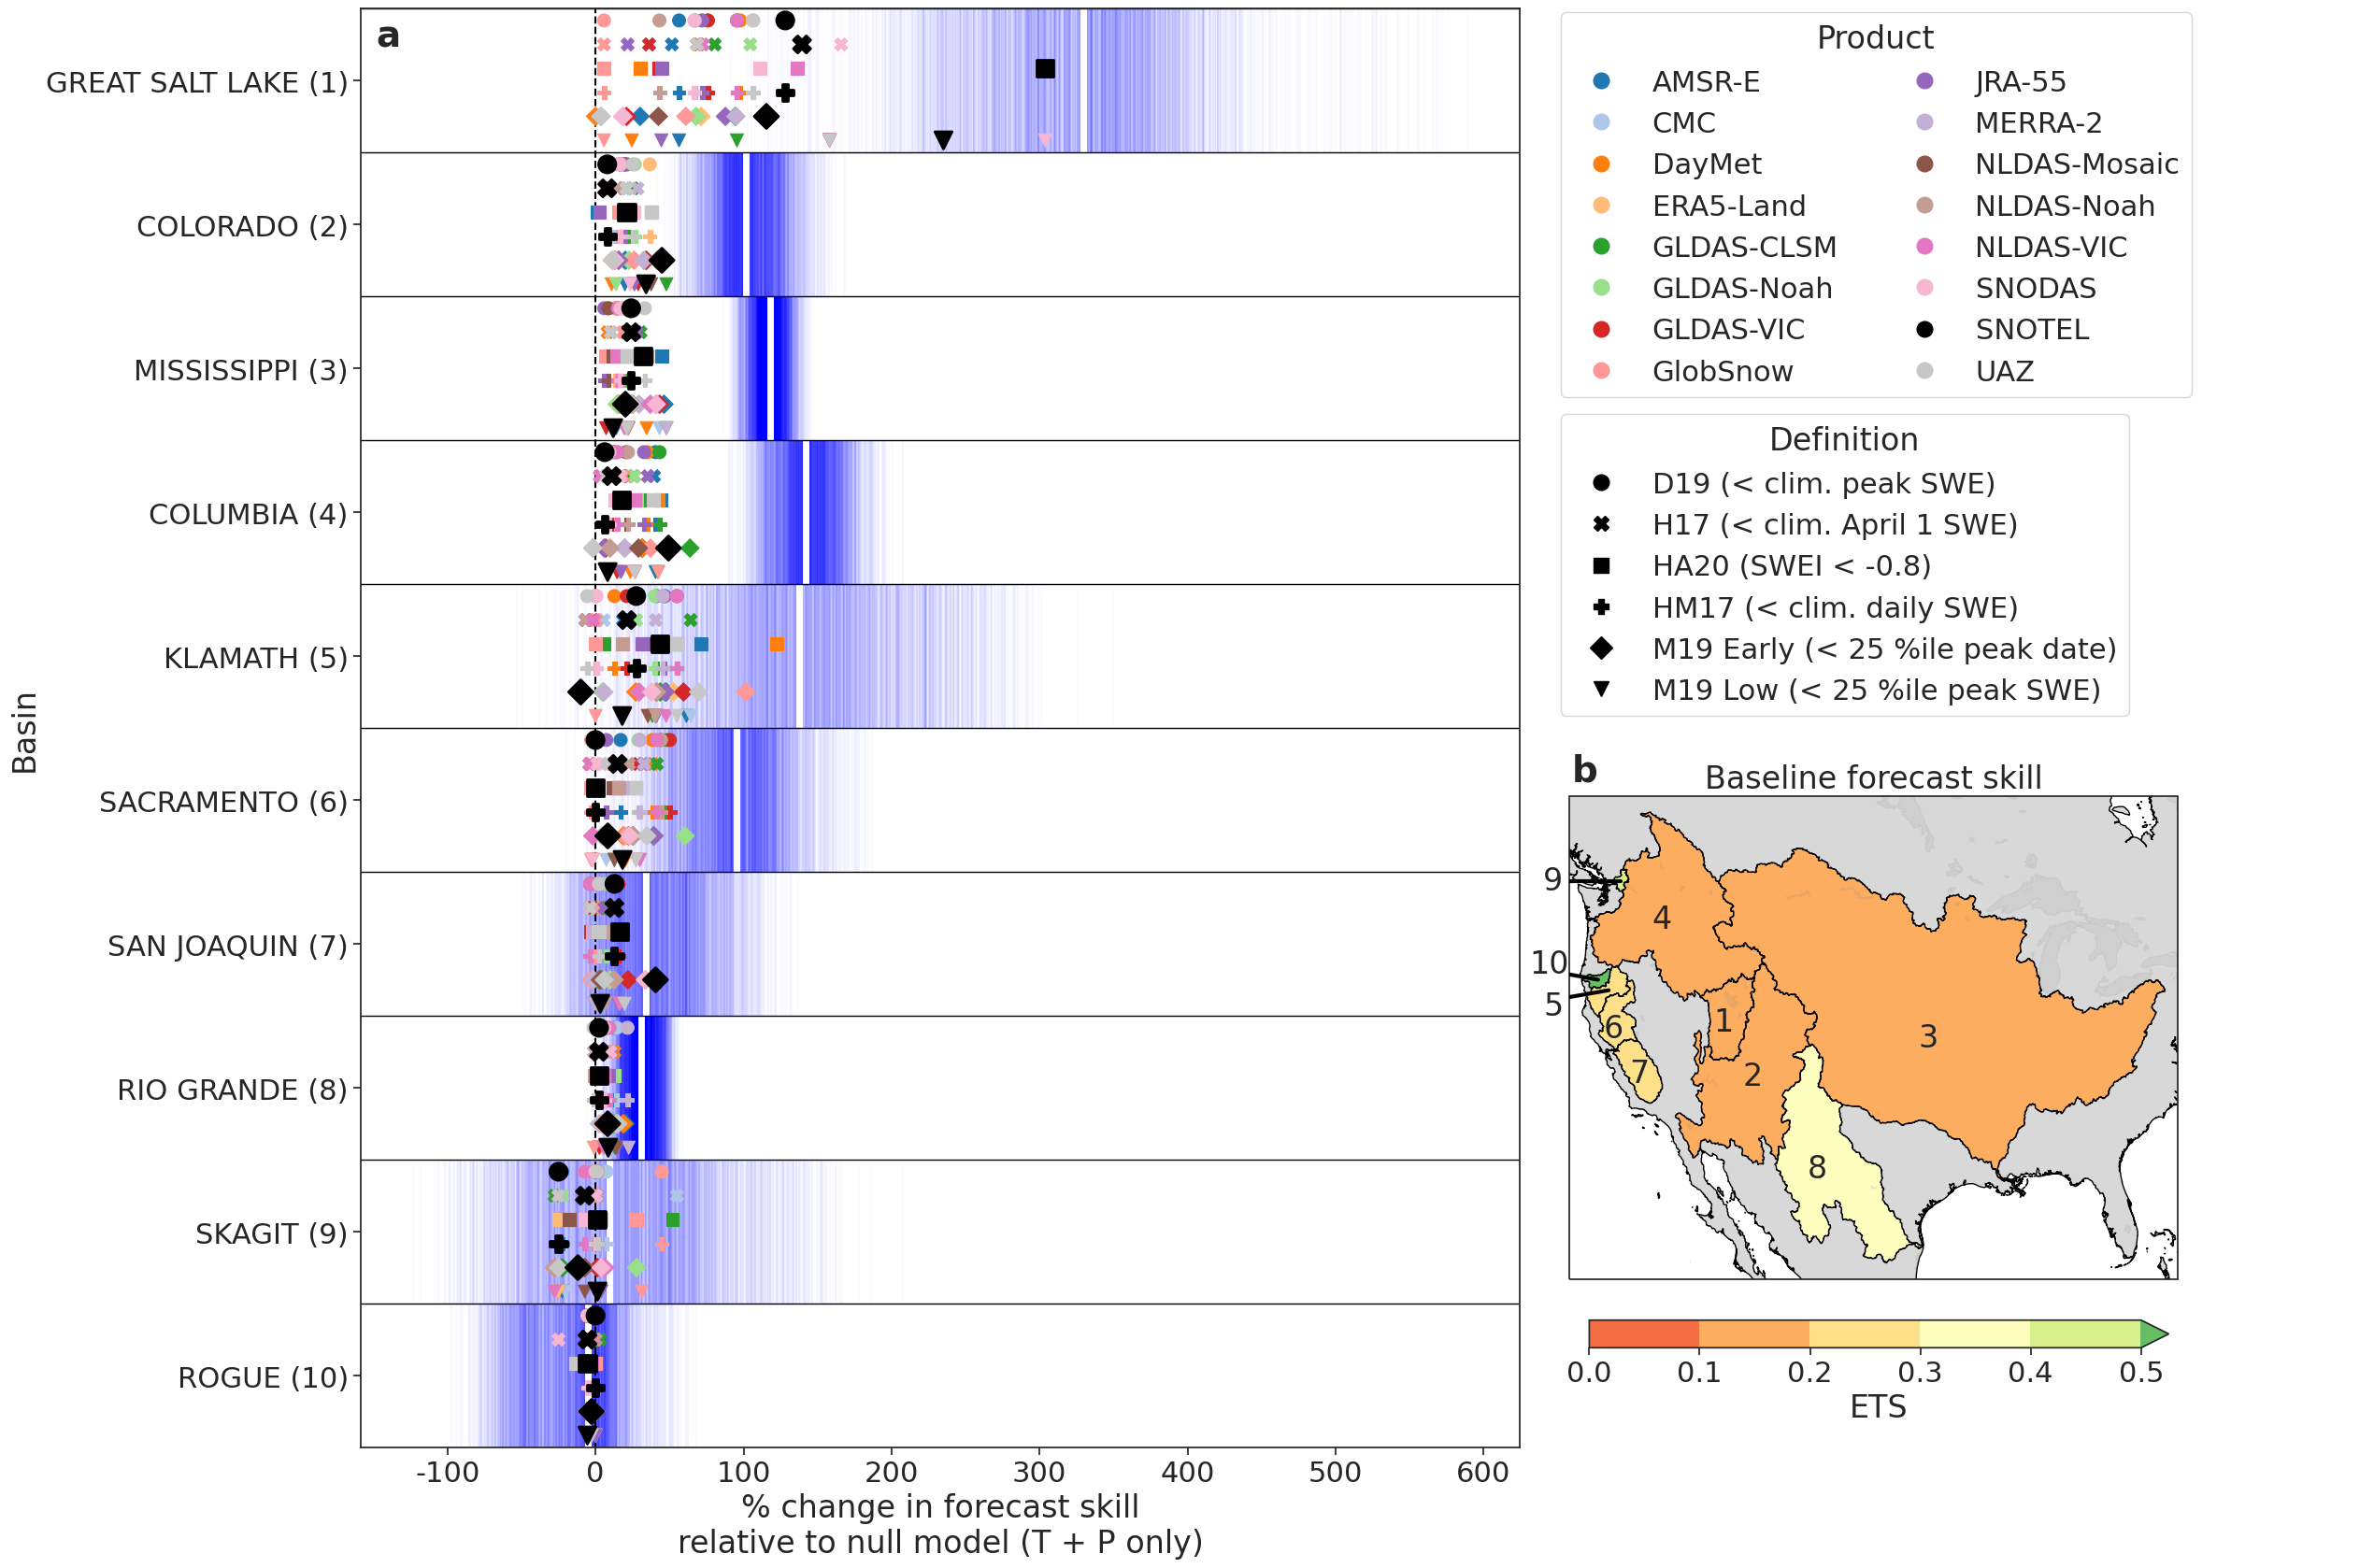

In [36]:
sns.set(style='ticks',font_scale=2)

fig, ax = plt.subplots(figsize=(16,20))

ax.axvline(0,linestyle='--',color='black') # dashed line indicating no change in forecast skill

# add horizontal lines separating basins
for k,v in basin_y_rev.items():
    ax.axhline(v+1.5,lw=1,color='black')
    
# sample 3000 estimates from empirical distribution of ensemble mean forecast skill in each basin
for idx,row in weighted_pct_null.loc[basin_order].iterrows():
    kde = gaussian_kde(row)
    X = kde.resample(3000,seed=42)
    ax.vlines(X,ymin=basin_y_rev[idx]-1.5,ymax=basin_y_rev[idx]+1.5,color='blue',alpha=0.1,lw=0.2) # add estimates as lines w/ same transparency to approximate conf. int.

# add white line indicating median estimate for each basin
ax.vlines(weighted_pct_null.median(axis=1).loc[basin_order],ymin=np.arange(0,10)*3-1.5,ymax=np.arange(0,10)*3+1.5,color='white',lw=5)

# plot estimates for each data-def combo in each basin, colored by product w/ marker indicating defintiion
sns.scatterplot(x='pct_null',y='basin_y',
                hue='product',style='definition',
                markers=marker_dict,
                edgecolor='face',
                linewidths=10,
                palette=color_dict,
                s=100,
                data=ets_med,
                legend=False,
                zorder=3.5,ax=ax)

# add SNOTEL on top
sns.scatterplot(x='pct_null',y='basin_y',
                style='definition',
                markers=marker_dict,
                edgecolor='black',
                linewidth=2,
                color=color_dict['SNOTEL'],
                s=175,
                data=ets_med[ets_med['product']=='SNOTEL'],
                legend=False,
                zorder=3.5,ax=ax)

# y-axis
ax.set_yticks(list(basin_y_rev.values())) # center ticks for labels
ylab = [basin_ids_rev[i] for i in basin_y_rev.keys()]
ylab = [re.sub("\([^)]*\)","",s).strip() for s in ylab] # remove alternate names from GRDC naming schemes
ynum = [f"({i})" for i in range(1,len(ylab)+1)][::-1] # numbers corresponding to inset map
ylab = list(map(' '.join, zip(ylab, ynum))) # add numbers to names
ax.set_yticklabels(ylab)
ax.set_ylabel("Basin")
ax.set_ylim(-1.5,len(basin_y_map)*3-1.5)


# x-axis
ax.set_xlabel("% change in forecast skill\nrelative to null model (T + P only)")
ax.set_xticklabels(np.arange(-200,701,100))

# product legend
leg1_handles = [Line2D([0],[0],color=prod_colors[i],linestyle='None',marker='o') for i in range(len(prods))]
leg = fig.legend(leg1_handles,prods,title='Product',markerscale=2,bbox_to_anchor=(1.475,0.84),ncol=2)

# definition legend
leg2_handles = [Line2D([0],[0],color='black',linestyle='None',marker=m) for m in marker_dict.values()]
leg2_labels = ['D19 (< clim. peak SWE)','H17 (< clim. April 1 SWE)','HA20 (SWEI < -0.8)',
               'HM17 (< clim. daily SWE)','M19 Early (< 25 %ile peak date)','M19 Low (< 25 %ile peak SWE)']
leg2 = fig.legend(handles=leg2_handles,labels=leg2_labels,bbox_to_anchor=(1.433,0.625),title="Definition",markerscale=2)



# create inset map showing baseline skill
ax_ins = inset_axes(ax, width="35%",height="50%",
                    loc="lower right",
                    bbox_to_anchor=(0.08,-0.1,1.5,1.5),
                    bbox_transform=ax.transAxes,
                    axes_class=geoaxes.GeoAxes,
                    axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
bounds = grdc_basins.loc[basin_order].geometry.total_bounds
ax_ins.set_extent([bounds[0]-1, bounds[2]+1, bounds[1]-1,bounds[3]+1], crs=ccrs.PlateCarree())

# colormap for baseline ETS
ets_cmap = plt.cm.get_cmap("RdYlGn")
ets_colors = [ets_cmap(i) for i in np.linspace(0.2,0.6,5)]
ets_cmap = mpl.colors.ListedColormap(ets_colors,name="ets")
ets_cmap.set_under(plt.cm.get_cmap("RdYlGn")(0))
ets_cmap.set_over(plt.cm.get_cmap("RdYlGn")(0.8))
ets_norm = plt.Normalize(vmin=0,vmax=0.5)

# plot map of basin-average skill
null_gdf.plot(ax=ax_ins, transform=ccrs.PlateCarree(), column='null_ets',edgecolor='black',cmap=ets_cmap,norm=ets_norm)
sm = plt.cm.ScalarMappable(cmap=ets_cmap,norm=ets_norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax_ins,pad=0.05, location='bottom', extend="max",panchor=False,anchor=(2.12,0.53),shrink=0.5)
cbar.ax.set_xlabel(r"ETS")

# add coastlines etc.
ax_ins.coastlines('10m')
ax_ins.add_feature(cartopy.feature.LAND, facecolor="grey",alpha=0.3)
ax_ins.add_feature(cartopy.feature.OCEAN,facecolor="white")
ax_ins.add_feature(cartopy.feature.LAKES,alpha=0.1,facecolor="grey")

# offsets from centroids of basin polygons for plotting numbers
xoff = [-3.9,-5.4,-1.2,-0.05,-0.35,-4.4,-1,0,0,-0.4][::-1]
yoff = [1,0,0,-0.2,-0.6,-1,0,-2,0,-0.3][::-1]
for i, b in enumerate(basin_order[::-1]):
    x,y = null_gdf.loc[b].geometry.centroid.xy # centoid of basin
    ax_ins.text(x[0]+xoff[i],y[0]+yoff[i],str(i+1),ha='center',va='center') # add number to plot
    if b in [89,51,256]: # draw line from centroid to number in small basins where number won't fit
        ax_ins.plot([x[0],x[0]+xoff[i]-3],[y[0],y[0]+yoff[i]],color='black',lw=3,zorder=3.5)
ax_ins.title.set_text("Baseline forecast skill")

# add labels for main plot and inset map
fig.text(0.135,0.86,"a",fontsize=28,fontweight="bold")
fig.text(0.935,0.467,"b",fontsize=28,fontweight="bold")

# plt.savefig(os.path.join(fig_dir,'basin_ets.png'),bbox_inches='tight')

## Null model: 
$$Pr(WSD) = logit^{-1}(\beta_0 + \beta_1 T + \beta_2 P)$$
where T is average AMJ temperature and P is cumulative AMJ precipitation.

## Individual dataset-definition combination: 
$$Pr(WSD) = logit^{-1}(\beta_0 + \beta_1 T + \beta_2 P + \beta_3 SD_{d,p})$$ where $SD_{d,p}$ is a binary variable indicating a snow drought as defined by applying definition $d$ to data product $p$. 

## Ensemble mean across all dataset-definition combinations (unweighted): 
$$Pr(WSD) = logit^{-1}(\beta_0 + \beta_1 T + \beta_2 P + \beta_3\frac{1}{n_dn_p}\sum_d\sum_p SD_{d,p})$$ where $n_d$ and $n_p$ are the numbers of definitions and datasets, respectively. Essentially, the last term is the fraction of all ensemble members that identify a snow drought in a given year.

## Ensemble mean across all dataset-definition combinations (weighted): 
$$Pr(WSD) = logit^{-1}(\beta_0 + \beta_1 T + \beta_2 P + \beta_3\frac{1}{n_dn_p}\sum_d\sum_p w_{d,p}SD_{d,p})$$ where $w_{d,p}$ is a weight proportional to the forecast skill (as quantified by ETS) of the dataset-definition combination. This gives ensemble members that are better predictors more weight in the ensemble mean.